In [13]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import Dataset, DataLoader

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
from google.colab import files
uploaded = files.upload()

Saving songsDataset.csv to songsDataset (1).csv


In [16]:
spd = pd.read_csv('songsDataset.csv')

In [17]:
spd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   'userID'  int64
 1   'songID'  int64
 2   'rating'  int64
dtypes: int64(3)
memory usage: 45.8 MB


In [18]:
print(spd["'userID'"].nunique())
print(spd["'songID'"].nunique())
print(spd["'rating'"].nunique())

200000
127771
5


In [19]:
spd["'rating'"].value_counts()

,count
'rating',
5,780134
1,399243
4,344972
3,287831
2,187820


In [20]:
spd.shape

(2000000, 3)

**Training Dataset Class Wrapper**

In [21]:
class songsDataset:
  def __init__(self, users, songs, ratings):
    self.users = users
    self.songs = songs
    self.ratings = ratings

  def __len__(self):
    return len(self.users)

  def __getitem__(self, index):
    users = self.users[index]
    songs = self.songs[index]
    ratings = self.ratings[index]

    return{
        'users': torch.tensor(users, dtype=torch.long),
        'songs': torch.tensor(songs, dtype=torch.long),
        'ratings': torch.tensor(ratings, dtype=torch.long)
    }

**Model Creation**

In [22]:
class RecSysModel (nn.Module):
  def __init__(self, n_users, n_songs):
    super().__init__()
    #its a trainable lookup matrix kinda for shallow embedding the vectors

    self.user_embeds = nn.Embedding(n_users, 32)
    self.song_embeds = nn.Embedding(n_songs, 32)
    self.out = nn.Linear(64, 1) #user, song embedd concat

  def forward(self, users, songs):
    user_embeds = self.user_embeds(users)
    song_embeds = self.song_embeds(songs)

    output = torch.cat([user_embeds, song_embeds], dim=1)

    output = self.out(output)

    return output

In [ ]:
#encoding the user and song id to start from 0 to avoid goinf for index out of
#bound with embedding
lbl_user = preprocessing.LabelEncoder()
lbl_song = preprocessing.LabelEncoder()
spd["'userID'"] = lbl_user.fit_transform(spd["'userID'"].values)
spd["'songID'"] = lbl_song.fit_transform(spd["'songID'"].values)

spd_train,spd_valid = model_selection.train_test_split(spd, test_size=0.1,
random_state=42, stratify=spd["'rating'"].values)

train_dataset = songsDataset(
    users=spd_train["'userID'"].values,
    songs=spd_train["'songID'"].values,
    ratings=spd_train["'rating'"].values
    )

valid_dataset = songsDataset(
    users=spd_valid["'userID'"].values,
    songs=spd_valid["'songID'"].values,
    ratings=spd_valid["'rating'"].values
    )

In [24]:
train_loader = DataLoader(train_dataset,
                          batch_size=5,
                          shuffle=True,
                          num_workers=2)

validation_loader = DataLoader(valid_dataset,
                               batch_size=5,
                               shuffle=True,
                               num_workers=2)

dataiter = iter(train_loader)
dataLoader_data = next(dataiter)
print(dataLoader_data)

{'users': tensor([ 86866, 125207, 181761, 175095,  15124]), 'songs': tensor([118988,  95224,  80203,  24910,  96440]), 'ratings': tensor([5, 5, 1, 5, 5])}


In [25]:
model = RecSysModel(n_users = len(lbl_user.classes_),
                    n_songs=len(lbl_song.classes_),
                    ).to(device)

opitmizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(opitmizer, step_size=3, gamma=0.7)
loss_func = nn.MSELoss()

In [26]:
print(len(lbl_user.classes_))
print(len(lbl_song.classes_))
print(spd["'songID'"].max())
print(len(train_dataset))

200000
127771
127770
1800000


**Manually Running a F/W path**

In [27]:
print(dataLoader_data['users'])
print(dataLoader_data['users'].size())
print(dataLoader_data['songs'])
print(dataLoader_data['songs'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
song_embed = nn.Embedding(len(lbl_song.classes_), 32)

out = nn.Linear(64, 1)

tensor([ 86866, 125207, 181761, 175095,  15124])
torch.Size([5])
tensor([118988,  95224,  80203,  24910,  96440])
torch.Size([5])


In [28]:
user_embeds = user_embed(dataLoader_data['users'])
song_embeds = song_embed(dataLoader_data['songs'])

print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"song_embeds {song_embeds.size()}")
print(f"song_embeds {song_embeds}")

user_embeds torch.Size([5, 32])
user_embeds tensor([[ 4.1675e-02, -2.7056e+00, -2.7718e-01,  1.2087e+00,  4.6899e-01,
          6.3461e-01,  5.8829e-01, -1.2359e+00, -2.5406e-01,  1.5416e-01,
         -1.1531e+00,  1.1399e-01, -1.7949e+00,  1.0228e+00,  1.6404e+00,
          2.6431e-01, -7.5138e-01, -1.7078e+00, -2.9170e+00,  7.5130e-01,
         -4.6897e-01,  1.1811e+00,  4.5197e-01,  1.7523e+00, -1.5246e+00,
          2.4351e-01, -1.3432e-01, -1.2445e+00,  3.2152e-01, -2.3583e-01,
         -9.1986e-01,  6.6202e-01],
        [-2.1352e+00,  1.5966e+00,  4.6736e-01, -2.0415e+00, -4.5334e-01,
         -4.0955e-01, -2.3953e-01, -2.1565e-01, -7.1282e-02, -6.6610e-01,
          1.1275e+00, -7.9226e-01,  1.3300e+00, -6.0951e-01, -9.1883e-01,
          3.1173e-01,  1.4150e+00,  1.1581e-01,  1.0882e-01,  1.2153e+00,
         -2.6654e-01, -2.2977e-01,  2.1920e-03, -5.5100e-01,  1.0103e+00,
          1.0093e+00,  1.6520e+00,  8.8009e-01,  6.7559e-01,  1.3690e+00,
          1.9763e-01, -3.6482e-0

In [29]:
output = torch.cat([user_embeds, song_embeds], dim=1)
print(output.size())
print(output)
output = out(output)
print(output)

torch.Size([5, 64])
tensor([[ 4.1675e-02, -2.7056e+00, -2.7718e-01,  1.2087e+00,  4.6899e-01,
          6.3461e-01,  5.8829e-01, -1.2359e+00, -2.5406e-01,  1.5416e-01,
         -1.1531e+00,  1.1399e-01, -1.7949e+00,  1.0228e+00,  1.6404e+00,
          2.6431e-01, -7.5138e-01, -1.7078e+00, -2.9170e+00,  7.5130e-01,
         -4.6897e-01,  1.1811e+00,  4.5197e-01,  1.7523e+00, -1.5246e+00,
          2.4351e-01, -1.3432e-01, -1.2445e+00,  3.2152e-01, -2.3583e-01,
         -9.1986e-01,  6.6202e-01,  2.5209e-01, -5.5119e-01, -1.3506e+00,
         -3.1698e-01,  1.5571e+00,  5.8502e-01, -3.6299e-01, -2.2908e+00,
          8.4119e-01,  1.2810e+00, -1.4904e+00,  8.7788e-03,  1.4376e-01,
         -1.5699e+00,  9.9398e-01,  1.7115e+00, -2.3556e-01,  5.3747e-01,
         -1.6035e-01,  1.2165e+00, -2.9164e-02, -5.4306e-01,  5.9248e-01,
         -8.7810e-01, -1.5316e+00,  1.2824e+00,  7.2037e-02,  8.0169e-01,
          1.8865e+00,  1.2286e+00, -3.8301e-01, -2.6913e-01],
        [-2.1352e+00,  1.5966e

In [30]:
with torch.no_grad():
  model_output = model(dataLoader_data['users'].to(device),
                       dataLoader_data['songs'].to(device))

  print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[-0.3751],
        [-0.6680],
        [-0.1223],
        [-0.2060],
        [-0.4464]], device='cuda:0'), size: torch.Size([5, 1])


In [31]:
rating = dataLoader_data['ratings']
print(rating)
print(rating.view(5,-1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([5, 5, 1, 5, 5])
tensor([[5],
        [5],
        [1],
        [5],
        [5]])
tensor([[-0.3751],
        [-0.6680],
        [-0.1223],
        [-0.2060],
        [-0.4464]], device='cuda:0')
tensor(21)
tensor(-22.8179, device='cuda:0')


**Run for training loop**

In [ ]:
epochs = 1 #in initial phase that's why kept it to 1
total_loss = 0
plot_steps, print_steps= 10000,10000
step_cnt = 0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
  for i, train_data in enumerate(train_loader):
    users = train_data["users"].to(device)
    songs = train_data["songs"].to(device)
    ratings = train_data["ratings"].to(device) 
    output = model(users, songs)
    ratings = ratings.view(5, -1).to(torch.float32)

    loss= loss_func(output, ratings)
    total_loss += loss.sum().item()
    opitmizer.zero_grad()
    loss.backward()
    opitmizer.step()

    step_cnt += len(users)

    if (step_cnt % plot_steps == 0):
      avg_loss = total_loss / (len(train_data["users"])*plot_steps)#calculated for relative monitoring
      print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
      all_losses_list.append(avg_loss)
      total_loss = 0

epoch 0 loss at step: 10000 is 0.39179439489126205
epoch 0 loss at step: 20000 is 0.16147071049928666
epoch 0 loss at step: 30000 is 0.10204484183698892
epoch 0 loss at step: 40000 is 0.09803517156362533
epoch 0 loss at step: 50000 is 0.095335178155303
epoch 0 loss at step: 60000 is 0.09871050002038478
epoch 0 loss at step: 70000 is 0.0968177415817976
epoch 0 loss at step: 80000 is 0.09892658076226711
epoch 0 loss at step: 90000 is 0.09683792481988668
epoch 0 loss at step: 100000 is 0.09745352990478277
epoch 0 loss at step: 110000 is 0.09577400443702937
epoch 0 loss at step: 120000 is 0.09791345076858997
epoch 0 loss at step: 130000 is 0.09665704560637474
epoch 0 loss at step: 140000 is 0.09569490080535412
epoch 0 loss at step: 150000 is 0.09771916841357946
epoch 0 loss at step: 160000 is 0.09660410181701183
epoch 0 loss at step: 170000 is 0.09718286159723998
epoch 0 loss at step: 180000 is 0.09693808938890695
epoch 0 loss at step: 190000 is 0.09702978899031878
epoch 0 loss at step: 20

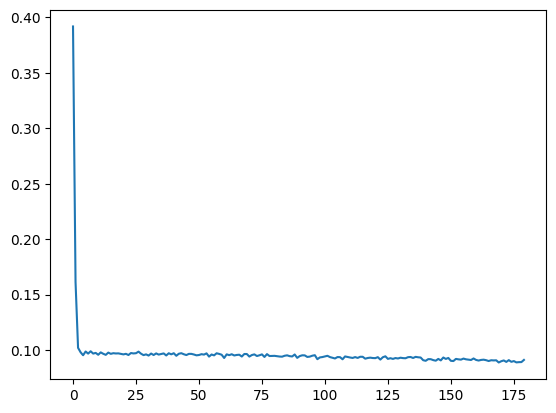

In [33]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

**A comparative evaluation with RMSE and Recall@K**

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

model_output_list=[]
target_rating_list=[]

model.eval()

with torch.no_grad():
  for i, batched_data in enumerate(validation_loader):
    users = batched_data["users"].to(device)
    songs = batched_data["songs"].to(device)
    ratings = batched_data["ratings"].to(device)

    model_output = model(users, songs)

    model_output_list.append(model_output.mean().item())
    target_rating_list.append(ratings.float().mean().item())

    # Optional: print for debugging if needed but can rmove for fadtrr evaluation
    # print(f"model_output: {model_output}")
    # print(f"target_rating: {ratings}")

mse = mean_squared_error(target_rating_list, model_output_list)
rms = np.sqrt(mse)
print(f"rms: {rms}")

rms: 0.6709697311090022


In [35]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
  for i, batched_data in enumerate(validation_loader):
    users = batched_data["users"].to(device)
    songs = batched_data["songs"].to(device)
    ratings = batched_data["ratings"].to(device)

    model_output = model(users, songs)

    for i in range(len(users)):
      user_id = users[i].item()
      song_id = songs[i].item()
      est_rating = model_output[i][0].item()
      true_rating = ratings[i].item()

      print(f"{user_id}, {song_id}, {est_rating},{true_rating}")
      user_est_true[user_id].append((est_rating, true_rating))


Streaming output truncated to the last 5000 lines.
144949, 10775, 3.9922361373901367,5
60102, 84034, 3.4552345275878906,5
10557, 59673, 3.1366307735443115,2
107976, 22565, 3.216026782989502,3
187857, 54111, 3.610836982727051,1
87321, 120061, 3.906639814376831,5
1665, 73526, 3.4448139667510986,2
135156, 93070, 2.638697385787964,1
153299, 50384, 3.379443645477295,1
2226, 73543, 3.339764356613159,1
40537, 59757, 3.181506395339966,2
149021, 76718, 3.281520128250122,1
38725, 116193, 2.9213149547576904,3
108266, 19602, 4.163670539855957,5
75998, 72684, 2.833930015563965,5
12157, 15429, 3.3712732791900635,3
180839, 75001, 2.6877388954162598,3
58868, 32704, 3.7859385013580322,5
16821, 2821, 3.1642818450927734,3
87556, 44079, 3.855215549468994,5
158806, 90781, 3.2405927181243896,3
75819, 45595, 3.974402666091919,3
112333, 88227, 3.0786828994750977,1
75247, 97720, 4.200935363769531,3
79300, 115782, 3.1904942989349365,3
42612, 84998, 2.9721274375915527,2
89815, 84742, 3.1273000240325928,2
146283,

In [36]:
with torch.no_grad():
  precisions = dict()
  recalls = dict()

  k=100
  threshold = 3.5

  for uid, user_ratings in user_est_true.items():

    user_ratings.sort(key=lambda x: x[0], reverse=True)

    n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

    n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

    n_rel_and_rec_k = sum(
        ((true_r >= threshold) and (est >= threshold))
          for (est, true_r) in user_ratings[:k]
        )

    print(f"uid: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}")

    precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

    recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

Streaming output truncated to the last 5000 lines.
uid: 155336, n_rel: 0, n_rec_k: 1, n_rel_and_rec_k: 0
uid: 1476, n_rel: 1, n_rec_k: 1, n_rel_and_rec_k: 1
uid: 189222, n_rel: 1, n_rec_k: 1, n_rel_and_rec_k: 1
uid: 199250, n_rel: 0, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 163563, n_rel: 0, n_rec_k: 1, n_rel_and_rec_k: 0
uid: 131488, n_rel: 1, n_rec_k: 1, n_rel_and_rec_k: 1
uid: 139417, n_rel: 1, n_rec_k: 1, n_rel_and_rec_k: 1
uid: 137416, n_rel: 0, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 79058, n_rel: 0, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 50651, n_rel: 0, n_rec_k: 1, n_rel_and_rec_k: 0
uid: 11502, n_rel: 0, n_rec_k: 1, n_rel_and_rec_k: 0
uid: 3695, n_rel: 0, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 74951, n_rel: 1, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 38786, n_rel: 0, n_rec_k: 1, n_rel_and_rec_k: 0
uid: 61843, n_rel: 0, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 98664, n_rel: 1, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 178401, n_rel: 0, n_rec_k: 0, n_rel_and_rec_k: 0
uid: 55362, n_rel: 0, n_rec_k: 0, n_rel_an

In [37]:
print(f"precision@: {k} : {sum(prec for prec in precisions.values()) / len(precisions)}")
print(f"recall@: {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision@: 100 : 0.35377552536398943
recall@: 100 : 0.3507687066465845


In [41]:
model_save_path = 'recsys_model_updated.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to recsys_model_updated.pth


In [ ]:
# Example of how to load the model later
# define your model architecture (make sure it's the same as when you saved)

#-----loaded_model = RecSysModel(n_users=len(lbl_user.classes_), n_songs=len(lbl_song.classes_))----

# Load the saved state dictionary

#-----loaded_model.load_state_dict(torch.load('recsys_model_updated.pth'))------

# Move the loaded model to the appropriate device

#-----loaded_model.to(device)------

# Set the model to evaluation mode if you are using it for inference

#-----loaded_model.eval()------
#-----print("Model loaded successfully!")------

In [43]:
import pickle

user_encoder_save_path = 'lbl_user_updated.pkl'
song_encoder_save_path = 'lbl_song_updated.pkl'

# Saving lbl products
with open(user_encoder_save_path, 'wb') as f:
    pickle.dump(lbl_user, f)

with open(song_encoder_save_path, 'wb') as f:
    pickle.dump(lbl_song, f)

print(f"Label encoders saved to {user_encoder_save_path} and {song_encoder_save_path}")

Label encoders saved to lbl_user_updated.pkl and lbl_song_updated.pkl
